In [4]:
## import library
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

In [9]:
## load the fire data frame and telangana shape data
csv_PATH = "telangana_fires.csv"
telangana_fires_orginal_df = pd.read_csv(csv_PATH)

PATH_shape = "telangana_shapefile.geojson"
india_shapefile = gpd.read_file(PATH_shape)
telangana_fires_orginal_df["geometry"] = gpd.points_from_xy(telangana_fires_orginal_df["longitude"], telangana_fires_orginal_df["latitude"])
telangana_fires_orginal_df = gpd.GeoDataFrame(telangana_fires_orginal_df)

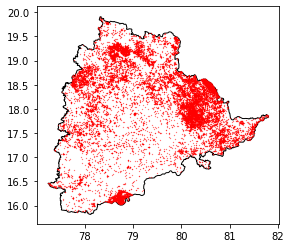

In [10]:
## draw the fire data point vs telangana 
base = india_shapefile.plot(color='white', edgecolor='black')
telangana_fires_orginal_df.plot(ax=base, marker='o', color='red', markersize=0.05);

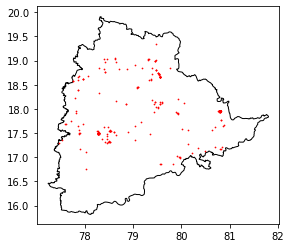

In [11]:
## fire caused by other static land source
potential_corp_fire = telangana_fires_orginal_df[telangana_fires_orginal_df["type"] == 2]
base = india_shapefile.plot(color='white', edgecolor='black')
potential_corp_fire.plot(ax=base, marker='o', color='red', markersize=0.5);

In [83]:
## explore the fire data
# telangana_fires_orginal_df.head()

In [12]:
## numpy  with cont variables:
telangana_fires_cont = telangana_fires_orginal_df[['brightness', 'scan', 'track',
       'confidence','bright_t31', 'frp']]

## convert to numpy
telangana_fires_cont_np = telangana_fires_cont.to_numpy()

## numpy  with categorical variables:
telangana_categrical = telangana_fires_orginal_df[['daynight','type']]
## one-hot encode categorical variable
telangana_categrical_encoded = OneHotEncoder().fit_transform(telangana_categrical).toarray()

## combine two dataframe and scale and normalize data
telangana_fires_np = np.concatenate((telangana_fires_cont_np,telangana_categrical_encoded),axis=1)
telangana_fires_np_scaled = StandardScaler().fit_transform(telangana_fires_np)

[167340.63043534156, 122221.78694150406, 88782.89787005755, 60058.98139116932, 42965.89304648699, 36634.46032427969, 30950.671543632878, 27482.770524454645, 24371.903143921394]


AttributeError: ignored

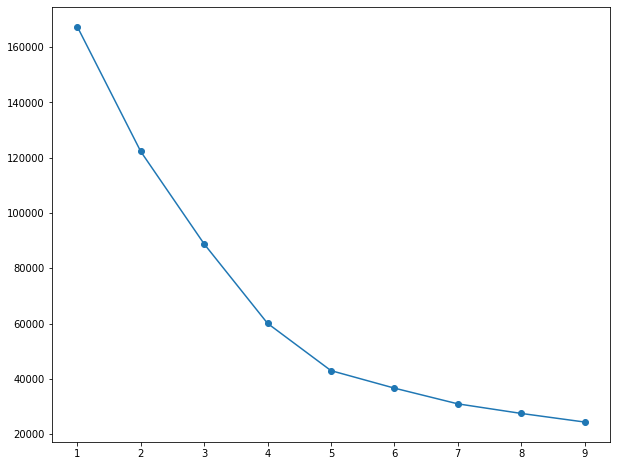

In [21]:
from matplotlib import markers
##fit in PCA and pick top 4 most significant value
pca = PCA(n_components = 4).fit(telangana_fires_np_scaled)
telangana_fires_pca = pca.transform(telangana_fires_np_scaled)
wcss = []
## use k means to cluster data into 2 cluster
for i in range(1,10):
  Kmean = KMeans(n_clusters=i)
  Kmean.fit(telangana_fires_pca)
  wcss.append(Kmean.inertia_)

print(wcss)
plt.figure(figsize = (10,8))
plt.plot(range(1,10),wcss,marker = "o")

In [23]:
Kmean = KMeans(n_clusters=4)
## put clusted lable to orginal fire data frame
Kmean.fit(telangana_fires_pca)
telangana_fires_orginal_df["label"] = Kmean.labels_

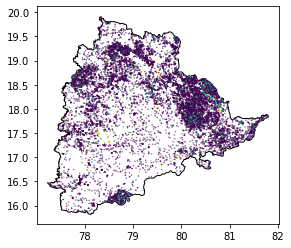

In [24]:
## print out labeled data vs telangana shape
base = india_shapefile.plot(color='white', edgecolor='black')
telangana_fires_orginal_df.plot(column = "label",ax=base, marker='o',  markersize=0.1);

In [28]:
potential_corp_fire = telangana_fires_orginal_df[telangana_fires_orginal_df["type"] == 0]
potential_corp_fire.head(5)
# telangana_fires_orginal_df[telangana_fires_orginal_df["label"] == 1]


,fireID,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,geometry,label
0,0,18.3777,80.5314,318.6,1.0,1.0,02/01/15,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0,POINT (80.53140 18.37770),0
1,1,17.5898,80.9893,315.4,1.2,1.1,04/01/15,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0,POINT (80.98930 17.58980),0
2,2,17.6028,81.1612,311.8,1.2,1.1,05/01/15,527,Terra,MODIS,46,6.03,299.8,6.0,D,0,POINT (81.16120 17.60280),0
3,3,17.5241,80.3135,317.0,1.1,1.0,05/01/15,527,Terra,MODIS,69,6.03,302.0,9.3,D,0,POINT (80.31350 17.52410),0
4,4,17.7571,80.3404,317.2,2.5,1.5,05/01/15,833,Aqua,MODIS,53,6.03,300.0,29.3,D,0,POINT (80.34040 17.75710),2


In [113]:
telangana_fires_orginal_df[["fireID","label"]].to_json("output2.json")